# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [181]:
%%bash
pip install --upgrade pip
pip3 install scikit-learn

Requirement already up-to-date: pip in /opt/conda/lib/python3.6/site-packages (18.1)


In [182]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import time
# from sklearn.impute import SimpleImputer : cannot use in sklearn ver 0.19.1
from sklearn.preprocessing import Imputer

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_columns = None  # show all columns

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [169]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [114]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('\n The first five rows of azdias data.')
azdias.head()


 The first five rows of azdias data.


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4            0   
1                      4                 5          1         1996   
2                      3                 5          1         1979   
3                      1                 2          6         1957   
4                      3                 2          5         1963   

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0             10.0                 0          -1                 15.0   
1             10.0                 0           3                 21.0   
2             10.0                 1           3                  3.0   
3              1.0                 0           2                  0.0   
4              5.0                 0           3                 32.0   

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0                  4.0              2.0              2.0             1.0   
1                  6.0              5.0              3.0             2.0   
2                  1.0              1.0              1.0             3.0   
3                  0.0              0.0              0.0             9.0   
4                 10.0             10.0              5.0             3.0   

   LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  \
0             1.0                 0                      0             5.0   
1             1.0                 1                     14             1.0   
2             2.0                 1                     15             3.0   
3             4.0                 1                      8             2.0   
4             2.0                 1                      8             5.0   

   SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
0          2          6          7          5           1           5   
1          5          4          4          3           1           2   
2          4          1          3          3           4           4   
3          5          1          2          1           4           4   
4          6          4          4          2           7           4   

   SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
0          3           3          4           7          6           6   
1          2           3          6           4          7           4   
2          6           3          4           7          7           7   
3          7           4          3           4          4           5   
4          4           6          2           3          2           2   

   SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  TITEL_KZ  VERS_TYP  \
0              5            3           -1      NaN       NaN        -1   
1              7            6            3      1.0       0.0         2   
2              3            3            2      0.0       0.0         1   
3              4            4            1      0.0       0.0         1   
4              4            2            2      0.0       0.0         2   

   ZABEOTYP  ALTER_HH  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCO

In [115]:
print('\n The feature summary file.')
feat_info


 The feature summary file.


attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14             HEALTH_TYP            person      ordinal             [-1,0]
15    LP_LEBENSPHASE_FEIN            person        mixed                [0]
16    LP_LEBENSPHASE_GROB            person        mixed                [0]
17        LP_FAMILIE_FEIN            person  categorical                [0]
18        LP_FAMILIE_GROB            person  categorical                [0]
19         LP_STATUS_FEIN            person  categorical                [0]
20         LP_STATUS_GROB            person  categorical                [0]
21       NATIONALITAET_KZ            person  categorical             [-1,0]
22  PRAEGENDE_JUGENDJAHRE            person        mixed             [-1,0]
23         RETOURTYP_BK_S            person      ordinal                [0]
24              SEMIO_SOZ            person      ordinal             [-1,9]
25              SEMIO_FAM            person      ordinal             [-1,9]
26              SEMIO_REL            person      ordinal             [-1,9]
27              SEMIO_MAT            person      ordinal             [-1,9]
28             SEMIO_VERT            person      ordinal             [-1,9]
29             SEMIO_LUST            person      ordinal             [-1,9]
..                    ...               ...          ...                ...
55            OST_WEST_KZ          building  categorical               [-1]
56               WOHNLAGE          building        mixed               [-1]
57        CAMEO_DEUG_2015     microcell_rr4  categorical             [-1,X]
58         CAMEO_DEU_2015     microcell_rr4  categorical               [XX]
59        CAMEO_INTL_2015     microcell_rr4        mixed            [-1,XX]
60            KBA05_ANTG1     microcell_rr3      ordinal               [-1]
61            KBA05_ANTG2     microcell_rr3      ordinal               [-1]
62            KBA05_ANTG3     microcell_rr3      ordinal               [-1]
63            KBA05_ANTG4     microcell_rr3      ordinal               [-1]
64           KBA05_BAUMAX     microcell_rr3        mixed             [-1,0]
65              KBA05_GBZ     microcell_rr3      ordinal             [-1,0]
66               BALLRAUM          postcode      ordinal               [-1]
67               EWDICHTE          postcode      ordinal               [-1]
68             INNENSTADT          postcode      ordinal               [-1]
69     GEBAEUDETYP_RASTER        region_rr1      ordinal                 []
70                    KKK        region_rr1      ordinal             [-1,0]
71             MOBI_REGIO        region_rr1      ordinal                 []
72      ONLINE_AFFINITAET        region_rr1      ordinal                 []
73               REGIOTYP        region_rr1      ordinal             [-1,0]
74       KBA13_ANZAHL_PKW    macrocell_plz8      numeric                 []
75             PLZ8_ANTG1    macrocell_plz8      ordinal        

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [116]:
# Identify missing or unknown data values and convert them to NaNs.

In [117]:
# Just for backup

# This part is not used anymore now.
# Reason: Originlally, I used "for" * 2 & "if" * 1, but it tunred out to be too slow. (for one columnsit takes 10 mins)
# And I found that "map" method is dramastically faster than ever.

'''

def is_na_should(feat_info_attribute, string_value):
    
    <INPUT>
    
    feat_info_attribute: attribute name in feat_info
    string_value: the value that need to be substitute
    
    
    <OUTPUT>
    True (if the string_value is in missing_or_unknown);
    False (if the string_value is not in missing_or_unknown)
    
    
    
    value_str = feat_info[feat_info['attribute'] == feat_info_attribute]['missing_or_unknown'].iloc[0]
    value_list = value_str.strip('[]').split(',')
    
    for value in value_list:
        if string_value == value:
            is_exist = True
            break
        else:
            is_exist = False
            
    return is_exist
    
'''

"\n\ndef is_na_should(feat_info_attribute, string_value):\n    \n    <INPUT>\n    \n    feat_info_attribute: attribute name in feat_info\n    string_value: the value that need to be substitute\n    \n    \n    <OUTPUT>\n    True (if the string_value is in missing_or_unknown);\n    False (if the string_value is not in missing_or_unknown)\n    \n    \n    \n    value_str = feat_info[feat_info['attribute'] == feat_info_attribute]['missing_or_unknown'].iloc[0]\n    value_list = value_str.strip('[]').split(',')\n    \n    for value in value_list:\n        if string_value == value:\n            is_exist = True\n            break\n        else:\n            is_exist = False\n            \n    return is_exist\n    \n"

In [118]:
def nan_list_func(feat_info_attribute):
    '''
    <INPUT>
    feat_info_attribute: attribute name in feat_info    
    
    <OUTPUT>
    STRING LIST (the string value that should be substituted as np.nan)
    
    '''
    value_str = feat_info[feat_info['attribute'] == feat_info_attribute]['missing_or_unknown'].iloc[0]
    value_list = value_str.strip('[]').split(',')   
    
    return value_list





def int_float_fix(obj):
    '''
    Purpose: for an object that is float type, return the string integer to match the data dictionary.
    For the other types, return the string type. (nan is remain as nan)
    Ex: 
    3.0 -> '3'
    5.0 -> '5'
    nan -> nan
    'XX' -> 'XX'
    2 -> '2'
    
    <INPUT>
    objects with the following types: int, float, str
    
    <OUTPUT>
    str object
    
    '''
    if type(obj) == str or pd.isnull(obj):
        return obj
    else:
        return str(int(obj))

In [119]:
# Just for backup

# is_na_should('CAMEO_DEUG_2015', '-1')  # check the is_na_should

In [120]:
# Check the function

nan_list_func('CAMEO_DEUG_2015')

['-1', 'X']

In [121]:
# Substitute to Nans

azdias_original = azdias.copy()  # deep copy

for column in azdias.columns:
    # print(column)
    nan_list = nan_list_func(column)
    azdias[column] = azdias[column].map(lambda x: np.nan if int_float_fix(x) in nan_list else x)

In [122]:
azdias.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4          NaN   
1                      4                 5          1       1996.0   
2                      3                 5          1       1979.0   
3                      1                 2          6       1957.0   
4                      3                 2          5       1963.0   

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0             10.0                 0         NaN                 15.0   
1             10.0                 0         3.0                 21.0   
2             10.0                 1         3.0                  3.0   
3              1.0                 0         2.0                  NaN   
4              5.0                 0         3.0                 32.0   

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0                  4.0              2.0              2.0             1.0   
1                  6.0              5.0              3.0             2.0   
2                  1.0              1.0              1.0             3.0   
3                  NaN              NaN              NaN             9.0   
4                 10.0             10.0              5.0             3.0   

   LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  \
0             1.0               NaN                    NaN             5.0   
1             1.0               1.0                   14.0             1.0   
2             2.0               1.0                   15.0             3.0   
3             4.0               1.0                    8.0             2.0   
4             2.0               1.0                    8.0             5.0   

   SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
0          2          6          7          5           1           5   
1          5          4          4          3           1           2   
2          4          1          3          3           4           4   
3          5          1          2          1           4           4   
4          6          4          4          2           7           4   

   SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
0          3           3          4           7          6           6   
1          2           3          6           4          7           4   
2          6           3          4           7          7           7   
3          7           4          3           4          4           5   
4          4           6          2           3          2           2   

   SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  TITEL_KZ  VERS_TYP  \
0              5            3          NaN      NaN       NaN       NaN   
1              7            6          3.0      1.0       NaN       2.0   
2              3            3          2.0      0.0       NaN       1.0   
3              4            4          1.0      0.0       NaN       1.0   
4              4            2          2.0      0.0       NaN       2.0   

   ZABEOTYP  ALTER_HH  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCO

In [123]:
# Check for several columns
'''
AGER_TYP: -1, 0
ALTERSKATEGORIE_GROB : -1, 0, 9
CAMEO_DEUG_2015:  -1,X
CAMEO_DEU_2015: XX
'''
for column in ['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']:
    print('azdias_original： \n', azdias_original[column].value_counts(dropna=False))
    print('azdias： \n', azdias[column].value_counts(dropna=False), '\n \n \n')


azdias_original： 
 -1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64
azdias： 
 NaN     685843
 2.0     98472
 1.0     79802
 3.0     27104
Name: AGER_TYP, dtype: int64 
 
 

azdias_original： 
 3    358533
4    228510
2    158410
1    142887
9      2881
Name: ALTERSKATEGORIE_GROB, dtype: int64
azdias： 
  3.0    358533
 4.0    228510
 2.0    158410
 1.0    142887
NaN       2881
Name: ALTERSKATEGORIE_GROB, dtype: int64 
 
 

azdias_original： 
 8      134441
9      108177
6      105874
4      103912
NaN     98979
3       86779
2       83231
7       77933
5       55310
1       36212
X         373
Name: CAMEO_DEUG_2015, dtype: int64
azdias： 
 8      134441
9      108177
6      105874
4      103912
NaN     99352
3       86779
2       83231
7       77933
5       55310
1       36212
Name: CAMEO_DEUG_2015, dtype: int64 
 
 

azdias_original： 
 NaN    98979
6B     56672
8A     52438
4C     47819
2D     35074
3C     34769
7A     34399
3D     34307
8B    

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [124]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_evaluation = []

for column in azdias.columns:
    missing_ratio = (len(azdias[column]) - azdias[column].count()) / len(azdias[column])
    missing_evaluation.append(missing_ratio)

missing_eval = pd.DataFrame(data={'feature': azdias.columns, 
                     'missing_ratio': missing_evaluation}).sort_values(by='missing_ratio', ascending=False)
missing_eval.head(100)

feature  missing_ratio
40               TITEL_KZ       0.997576
0                AGER_TYP       0.769554
47           KK_KUNDENTYP       0.655967
64           KBA05_BAUMAX       0.534687
11            GEBURTSJAHR       0.440203
43               ALTER_HH       0.348137
70                    KKK       0.177357
73               REGIOTYP       0.177357
48         W_KEIT_KIND_HH       0.166051
60            KBA05_ANTG1       0.149597
61            KBA05_ANTG2       0.149597
62            KBA05_ANTG3       0.149597
63            KBA05_ANTG4       0.149597
65              KBA05_GBZ       0.149597
71             MOBI_REGIO       0.149597
77             PLZ8_ANTG3       0.130736
76             PLZ8_ANTG2       0.130736
81               PLZ8_GBZ       0.130736
80               PLZ8_HHZ       0.130736
75             PLZ8_ANTG1       0.130736
79            PLZ8_BAUMAX       0.130736
78             PLZ8_ANTG4       0.130736
41               VERS_TYP       0.124768
14             HEALTH_TYP       0.124768
38            SHOPPER_TYP       0.124768
21       NATIONALITAET_KZ       0.121536
22  PRAEGENDE_JUGENDJAHRE       0.121366
74       KBA13_ANZAHL_PKW       0.118714
50    ANZ_HAUSHALTE_AKTIV       0.111769
59        CAMEO_INTL_2015       0.111479
..                    ...            ...
3           CJT_GESAMTTYP       0.005446
19         LP_STATUS_FEIN       0.005446
20         LP_STATUS_GROB       0.005446
23         RETOURTYP_BK_S       0.005446
72      ONLINE_AFFINITAET       0.005446
1    ALTERSKATEGORIE_GROB       0.003233
8   FINANZ_UNAUFFAELLIGER       0.000000
10              FINANZTYP       0.000000
9        FINANZ_HAUSBAUER       0.000000
13       GREEN_AVANTGARDE       0.000000
5           FINANZ_SPARER       0.000000
4       FINANZ_MINIMALIST       0.000000
6        FINANZ_VORSORGER       0.000000
7          FINANZ_ANLEGER       0.000000
2               ANREDE_KZ       0.000000
35             SEMIO_KAEM       0.000000
24              SEMIO_SOZ       0.000000
36          SEMIO_PFLICHT       0.000000
25              SEMIO_FAM       0.000000
26              SEMIO_REL       0.000000
27              SEMIO_MAT       0.000000
28             SEMIO_VERT       0.000000
29             SEMIO_LUST       0.000000
30              SEMIO_ERL       0.000000
31             SEMIO_KULT       0.000000
32              SEMIO_RAT       0.000000
33             SEMIO_KRIT       0.000000
34              SEMIO_DOM       0.000000
37            SEMIO_TRADV       0.000000
42               ZABEOTYP       0.000000

[85 rows x 2 columns]

In [92]:
# Investigate patterns in the amount of missing data in each column.
fig = plt.figure(figsize = (200,200))
ax = fig.gca()
azdias.hist(ax = ax)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f595e56bc88>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f59ac61d668>]], dtype=object)

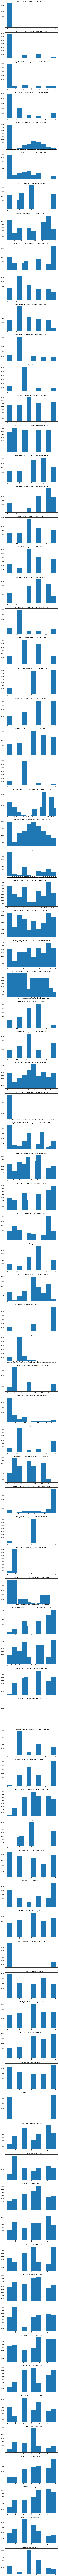

In [68]:
# plot histgram
i = 1
len_features = len(missing_eval)
plt.figure(figsize=(10, 500))

for index, row in missing_eval.iterrows():
    #print(i)
    #print(index)
    #print(row)
    #print('\n')
    #plt.subplot(len_features,1,i)
    plt.subplot(len_features,1,i)
    title_wording = str(row['feature']) + '    & missing_ratio = ' + str(row['missing_ratio'])
    plt.title(title_wording)
    plt.hist(azdias[row['feature']].map(lambda x: str(x)))
    i += 1
    if i > len_features:
        break

In [125]:
# check the white graph (plain graph) in above
azdias['LP_STATUS_FEIN'].value_counts()

1.0     219275
9.0     143238
2.0     118236
10.0    118022
4.0      78317
5.0      74493
3.0      74105
6.0      30914
8.0      19708
7.0      10059
Name: LP_STATUS_FEIN, dtype: int64

In [126]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias = azdias.drop(['TITEL_KZ','AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'], axis=1)


#### Discussion 1.1.2: Assess Missing Data in Each Column

`(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)`

Answer: 
After calculating the proportion of missing value in each feature column, one can find that there are 6 columns which are composed of more than 30% of missing values.
The 6 outlier features are 'TITEL_KZ','AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR' and 'ALTER_HH'.
Therefore, I removed the 6 features through `drop method`.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

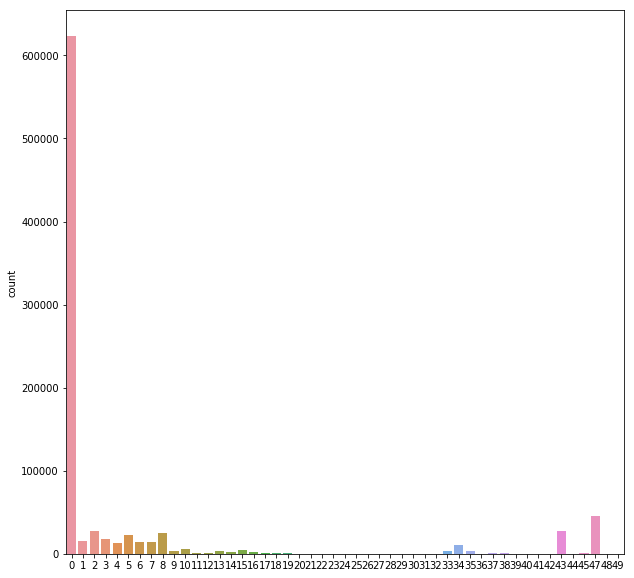

In [127]:
# How much data is missing in each row of the dataset?
plt.figure(figsize=(10, 10))
sns.countplot(len(azdias.columns) - azdias.count(axis=1))

In [128]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias['nans_row'] = len(azdias.columns) - azdias.count(axis=1)

criterion = 9
azdias_informative = azdias[azdias['nans_row'] < criterion]
azdias_noninformative = azdias[azdias['nans_row'] >= criterion]

In [129]:
len(azdias_informative) + len(azdias_noninformative)

891221

In [130]:
len(azdias)

891221

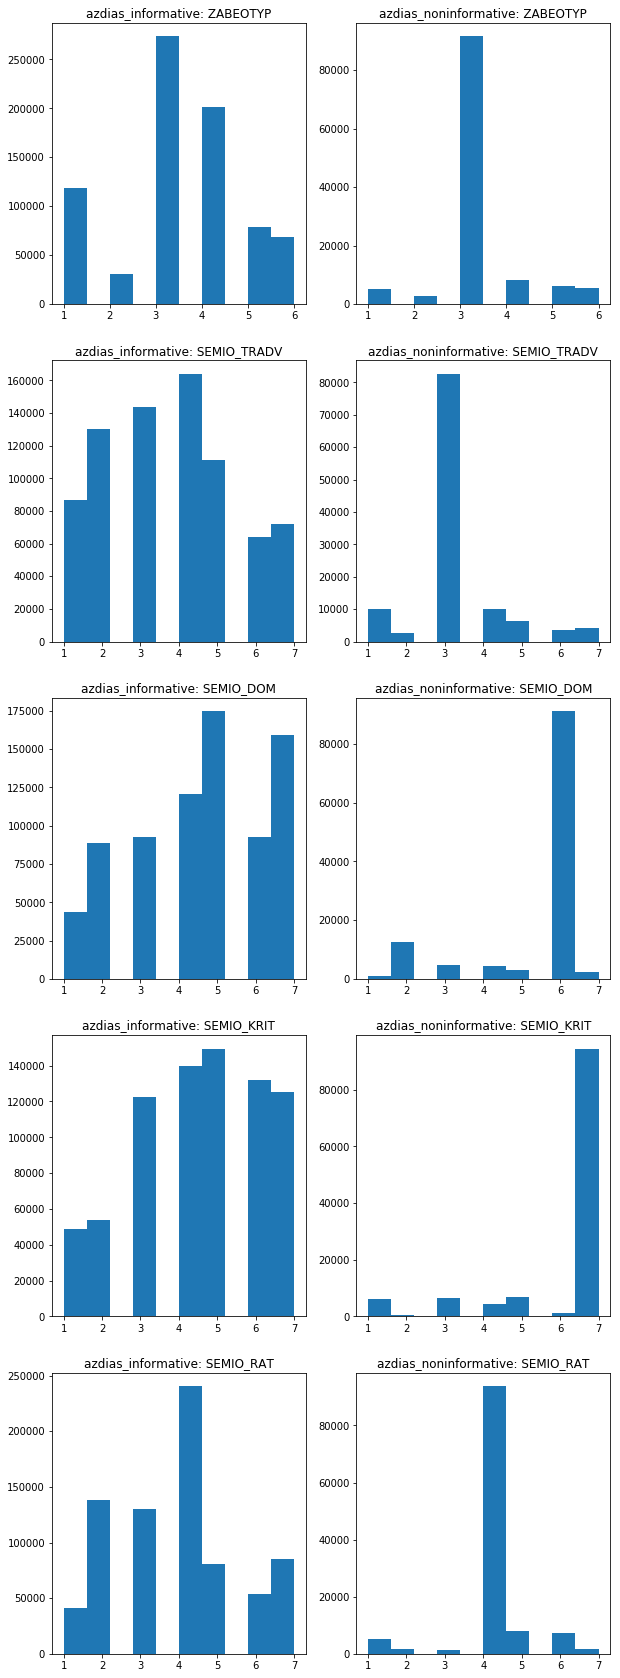

In [131]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# plot histgram with subplot
num_features = 5
num = 1
i = 1
plt.figure(figsize=(10, 30))

for index, row in missing_eval.iloc[::-1].iterrows():    
    plt.subplot(num_features, 2, num)
    title_wording = 'azdias_informative: ' + str(row['feature'])
    plt.title(title_wording)
    plt.hist(azdias_informative[row['feature']].map(lambda x: str(x)))
    
    plt.subplot(num_features, 2, num + 1)
    title_wording = 'azdias_noninformative: ' + str(row['feature'])
    plt.title(title_wording)
    plt.hist(azdias_noninformative[row['feature']].map(lambda x: str(x)))

    i += 1
    num += 2
    if i > num_features:
        break

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [132]:
# How many features are there of each data type?
feat_info_sub = feat_info[~feat_info['attribute'].isin(['TITEL_KZ','AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH'])]
feat_info_sub['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [133]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_feature_list = []
types_of_value_list = []
for feature in feat_info_sub[feat_info_sub['type'] == 'categorical']['attribute']:
    print(feature)
    print(azdias_informative[feature].value_counts(), '\n')
    categorical_feature_list.append(feature)
    types_of_value_list.append(len(azdias_informative[feature].value_counts()))

categorical_feat = pd.DataFrame({'categorical_feature': categorical_feature_list, 'types_of_value': types_of_value_list})
categorical_feat = categorical_feat.merge(missing_eval, how='inner', left_on='categorical_feature', right_on='feature')
categorical_feat


ANREDE_KZ
2    401965
1    369736
Name: ANREDE_KZ, dtype: int64 

CJT_GESAMTTYP
4.0    192713
3.0    143032
2.0    138816
5.0    108230
6.0     98233
1.0     90677
Name: CJT_GESAMTTYP, dtype: int64 

FINANZTYP
6    284638
1    190427
5    103458
2    100648
4     54474
3     38056
Name: FINANZTYP, dtype: int64 

GFK_URLAUBERTYP
12.0    124512
10.0    100733
8.0      81525
11.0     73530
5.0      69517
4.0      59937
9.0      55274
3.0      52656
1.0      49882
7.0      39604
2.0      39182
6.0      25349
Name: GFK_URLAUBERTYP, dtype: int64 

GREEN_AVANTGARDE
0    601545
1    170156
Name: GREEN_AVANTGARDE, dtype: int64 

LP_FAMILIE_FEIN
1.0     392886
10.0    126755
2.0      95786
11.0     48119
8.0      21254
7.0      18639
4.0      11225
5.0      10946
9.0      10261
6.0       7744
3.0       4388
Name: LP_FAMILIE_FEIN, dtype: int64 

LP_FAMILIE_GROB
1.0    392886
5.0    185135
2.0     95786
4.0     47637
3.0     26559
Name: LP_FAMILIE_GROB, dtype: int64 

LP_STATUS_FEIN
1.0     204094

categorical_feature  types_of_value           feature  missing_ratio
0            ANREDE_KZ               2         ANREDE_KZ       0.000000
1        CJT_GESAMTTYP               6     CJT_GESAMTTYP       0.005446
2            FINANZTYP               6         FINANZTYP       0.000000
3      GFK_URLAUBERTYP              12   GFK_URLAUBERTYP       0.005446
4     GREEN_AVANTGARDE               2  GREEN_AVANTGARDE       0.000000
5      LP_FAMILIE_FEIN              11   LP_FAMILIE_FEIN       0.087287
6      LP_FAMILIE_GROB               5   LP_FAMILIE_GROB       0.087287
7       LP_STATUS_FEIN              10    LP_STATUS_FEIN       0.005446
8       LP_STATUS_GROB               5    LP_STATUS_GROB       0.005446
9     NATIONALITAET_KZ               3  NATIONALITAET_KZ       0.121536
10         SHOPPER_TYP               4       SHOPPER_TYP       0.124768
11             SOHO_KZ               2           SOHO_KZ       0.082470
12            VERS_TYP               2          VERS_TYP       0.124768
13            ZABEOTYP               6          ZABEOTYP       0.000000
14         GEBAEUDETYP               7       GEBAEUDETYP       0.104517
15         OST_WEST_KZ               2       OST_WEST_KZ       0.104517
16     CAMEO_DEUG_2015               9   CAMEO_DEUG_2015       0.111479
17      CAMEO_DEU_2015              44    CAMEO_DEU_2015       0.111479

In [134]:
# Re-encode categorical variable(s) to be kept in the analysis.

# one binary variable that takes on non-numeric values
# OST_WEST_KZ

azdias_informative['OST_WEST_KZ'] = azdias_informative['OST_WEST_KZ'].map(lambda x: '0' if x == 'W' else '1')
azdias_informative['OST_WEST_KZ'].value_counts()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0    607911
1    163790
Name: OST_WEST_KZ, dtype: int64

In [140]:
azdias_informative[list(categorical_feat[categorical_feat['types_of_value'] > 2]['categorical_feature'])].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 771701 entries, 1 to 891220
Data columns (total 13 columns):
CJT_GESAMTTYP       771701 non-null float64
FINANZTYP           771701 non-null int64
GFK_URLAUBERTYP     771701 non-null float64
LP_FAMILIE_FEIN     748003 non-null float64
LP_FAMILIE_GROB     748003 non-null float64
LP_STATUS_FEIN      771701 non-null float64
LP_STATUS_GROB      771701 non-null float64
NATIONALITAET_KZ    741696 non-null float64
SHOPPER_TYP         739213 non-null float64
ZABEOTYP            771701 non-null int64
GEBAEUDETYP         771701 non-null float64
CAMEO_DEUG_2015     768362 non-null object
CAMEO_DEU_2015      768362 non-null object
dtypes: float64(9), int64(2), object(2)
memory usage: 82.4+ MB


'\nFor memo:\n\nDue to high correlation: \nLP_FAMILIE_FEIN -> Drop (Too detailed)\nLP_FAMILIE_GROB\n\nDue to high correlation: \nLP_STATUS_FEIN -> Drop (Too detailed)\nLP_STATUS_GROB \n\nDue to similar category: \nCAMEO_DEUG_2015\nCAMEO_DEU_2015 -> Drop (Too detailed)\n'

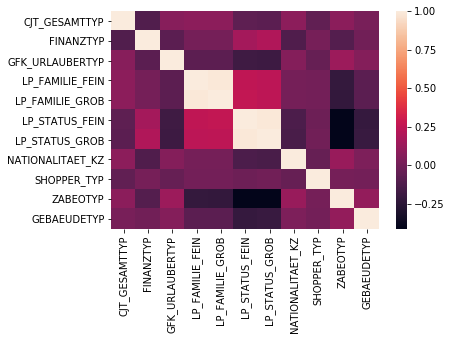

In [141]:
# Based on suggestions from udacity: Remove Redundant columns before  get_dummies()
# Or originally it will generate a very large number of features which may dilute the variability captured by components in the PCA step

sns.heatmap(azdias_informative[list(categorical_feat[categorical_feat['types_of_value'] > 2]['categorical_feature'])].corr())

'''
For memo:

Due to high correlation: 
LP_FAMILIE_FEIN -> Drop (Too detailed)
LP_FAMILIE_GROB

Due to high correlation: 
LP_STATUS_FEIN -> Drop (Too detailed)
LP_STATUS_GROB 

Due to similar category: 
CAMEO_DEUG_2015
CAMEO_DEU_2015 -> Drop (Too detailed)
'''

In [149]:
# re-coding with dummy variables

categories = categorical_feat[categorical_feat['types_of_value'] > 2]['categorical_feature']
categories = categories[~categories.isin(['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015'])]

azdias_informative_cat_dummy = pd.get_dummies(azdias_informative[list(categories)].astype(str))

In [150]:
# concat the non-catogorical features
non_catogorical_features = list(feat_info_sub[feat_info_sub['type'] != 'categorical']['attribute'])
   
azdias_informative_dummy = pd.concat([azdias_informative[non_catogorical_features], azdias_informative_cat_dummy], axis=1)


In [151]:
for column in azdias_informative_dummy.columns:
    print(column)

ALTERSKATEGORIE_GROB
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
HEALTH_TYP
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
PRAEGENDE_JUGENDJAHRE
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
KONSUMNAEHE
MIN_GEBAEUDEJAHR
WOHNLAGE
CAMEO_INTL_2015
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG1
PLZ8_ANTG2
PLZ8_ANTG3
PLZ8_ANTG4
PLZ8_BAUMAX
PLZ8_HHZ
PLZ8_GBZ
ARBEIT
ORTSGR_KLS9
RELAT_AB
CJT_GESAMTTYP_1.0
CJT_GESAMTTYP_2.0
CJT_GESAMTTYP_3.0
CJT_GESAMTTYP_4.0
CJT_GESAMTTYP_5.0
CJT_GESAMTTYP_6.0
FINANZTYP_1
FINANZTYP_2
FINANZTYP_3
FINANZTYP_4
FINANZTYP_5
FINANZTYP_6
GFK_URLAUBERTYP_1.0
GFK_URLAUBE

In [152]:
azdias_informative_dummy.head()

ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  \
1                   1.0                  1              5                 2   
2                   3.0                  1              4                 1   
3                   4.0                  4              2                 5   
4                   3.0                  4              3                 4   
5                   1.0                  3              1                 5   

   FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  HEALTH_TYP  \
1               5                      4                 5         3.0   
2               2                      3                 5         3.0   
3               2                      1                 2         2.0   
4               1                      3                 2         3.0   
5               2                      2                 5         3.0   

   LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  PRAEGENDE_JUGENDJAHRE  \
1                 21.0                  6.0                   14.0   
2                  3.0                  1.0                   15.0   
3                  NaN                  NaN                    8.0   
4                 32.0                 10.0                    8.0   
5                  8.0                  2.0                    3.0   

   RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  \
1             1.0          5          4          4          3           1   
2             3.0          4          1          3          3           4   
3             2.0          5          1          2          1           4   
4             5.0          6          4          4          2           7   
5             3.0          2          4          7          4           2   

   SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  \
1           2          2           3          6           4          7   
2           4          6           3          4           7          7   
3           4          7           4          3           4          4   
4           4          4           6          2           3          2   
5           2          2           5          7           4          4   

   SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  ANZ_PERSONEN  ANZ_TITEL  \
1           4              7            6           2.0        0.0   
2           7              3            3           1.0        0.0   
3           5              4            4           0.0        0.0   
4           2              4            2           4.0        0.0   
5           4              7            6           1.0        0.0   

   HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  \
1                 6.0             3.0             9.0                 11.0   
2                 4.0             3.0             9.0                 10.0   
3                 1.0             NaN             9.0                  1.0   
4                 5.0             2.0             9.0                  3.0   
5                 5.0             6.0             9.0                  5.0   

   ANZ_HH_TITEL  KONSUMNAEHE  MIN_GEBAEUDEJAHR  WOHNLAGE CAMEO_INTL_2015  \
1           0.0          1.0            1992.0       4.0              51   
2           0.0          5.0            1992.0       2.0              24   
3           0.0          4.0            1997.0       7.0              12   
4           0.0          4.0            1992.0       3.0              43   
5           0.0          5.0            1992.0       7.0              54   

   KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  KBA05_ANTG4  KBA05_GBZ  BALLRAUM  \
1          0.0          0.0          0.0          2.0        1.0       6.0   
2          1.0          3.0          1.0          0.0        3.0       2.0   
3          4.0          1.0          0.0          0.0        4.0       4.0   
4          1.0          4.0          1.0          0.0        3.0       2.0   
5          2.0   

In [153]:
# Check number of features
print('All features without too many missing data: ', len(feat_info_sub))
print('Categorical features: ', len(feat_info_sub[feat_info_sub['type'] == 'categorical']))
print('Categorical features (transformed to dummy variables):', len(azdias_informative_cat_dummy.columns))
print('Non catogorical features: ', len(non_catogorical_features))
print('Final data set features: ', len(azdias_informative_dummy.columns))

All features without too many missing data:  79
Categorical features:  18
Categorical features (transformed to dummy variables): 67
Non catogorical features:  61
Final data set features:  128


#### Discussion 1.2.1: Re-Encode Categorical Features

`(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)`

Answer: Regarding the categorical features, the binary parts are all transformed to numeric values.
Multi-level categoricals were firstly trimmed with correlation analysis and then were re-encoded by using dummy variables (get_dummies method).
The final dataset is azdias_informative_dummy, which has 128 columns.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [154]:
feat_info_sub[feat_info_sub['type'] == 'mixed']['attribute']

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [155]:
# investigate the mixed features
for feature in feat_info_sub[feat_info_sub['type'] == 'mixed']['attribute']:
    print(feature)
    print(azdias_informative[feature].value_counts())
    print('missing_ratio: ' , missing_eval[missing_eval['feature'] == feature]['missing_ratio'],  '\n')

LP_LEBENSPHASE_FEIN
1.0     58073
5.0     52122
6.0     42665
2.0     36849
8.0     28377
7.0     24811
29.0    24667
13.0    24444
11.0    23839
10.0    22618
31.0    22156
12.0    21044
30.0    20765
15.0    18815
3.0     18338
19.0    17697
37.0    17045
4.0     16353
20.0    16093
14.0    16019
32.0    15631
39.0    15015
40.0    14067
16.0    13460
35.0    12739
38.0    12722
27.0    12631
34.0    12018
21.0    11856
9.0     11693
24.0    11154
28.0    11047
36.0     9554
25.0     9544
23.0     8007
22.0     6696
18.0     6088
33.0     5667
17.0     5356
26.0     3261
Name: LP_LEBENSPHASE_FEIN, dtype: int64
missing_ratio:  15    0.109549
Name: missing_ratio, dtype: float64 

LP_LEBENSPHASE_GROB
2.0     147975
1.0     129613
3.0     104128
12.0     68403
4.0      50402
9.0      45432
5.0      45234
10.0     37787
11.0     30424
8.0      26939
6.0      26559
7.0      20698
Name: LP_LEBENSPHASE_GROB, dtype: int64
missing_ratio:  16    0.106115
Name: missing_ratio, dtype: float64 

PR

In [156]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_informative_dummy['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    177055
8.0     137517
10.0     83180
5.0      82984
3.0      52645
15.0     40684
11.0     34300
9.0      32901
6.0      25293
12.0     23861
4.0      20175
1.0      19974
2.0       7372
13.0      5497
7.0       3934
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [157]:
# Data_Dictionary.md : 1.18
# an interval-type variable for decade, and a binary variable for movement.

# PRAEGENDE_JUGENDJAHRE_DECADE
PRAEGENDE_JUGENDJAHRE_DECADE_df = pd.DataFrame(data={
    'PRAEGENDE_JUGENDJAHRE': list(range(1,16)),
    'PRAEGENDE_JUGENDJAHRE_DECADE': [4,4,5,5,6,6,6,7,7,8,8,8,8,9,9]
    })

# PRAEGENDE_JUGENDJAHRE_MOVEMENT
PRAEGENDE_JUGENDJAHRE_MOVEMENT_df = pd.DataFrame(data={
    'PRAEGENDE_JUGENDJAHRE': list(range(1,16)),
    'PRAEGENDE_JUGENDJAHRE_MOVEMENT': [1,2,1,2,1,2,2,1,2,1,2,1,2,1,2]
    })   #1: MainStream, 2: Avantgarde


azdias_informative_dummy = azdias_informative_dummy.merge(PRAEGENDE_JUGENDJAHRE_DECADE_df, how='left', on='PRAEGENDE_JUGENDJAHRE')
azdias_informative_dummy = azdias_informative_dummy.merge(PRAEGENDE_JUGENDJAHRE_MOVEMENT_df, how='left', on='PRAEGENDE_JUGENDJAHRE')
azdias_informative_dummy = azdias_informative_dummy.drop('PRAEGENDE_JUGENDJAHRE', axis=1)
azdias_informative_dummy

ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                        1.0                  1              5   
1                        3.0                  1              4   
2                        4.0                  4              2   
3                        3.0                  4              3   
4                        1.0                  3              1   
5                        2.0                  1              5   
6                        1.0                  3              3   
7                        3.0                  4              4   
8                        3.0                  2              4   
9                        3.0                  2              2   
10                       3.0                  5              3   
11                       1.0                  1              4   
12                       4.0                  4              1   
13                       1.0                  4              3   
14                       2.0                  2              4   
15                       3.0                  5              2   
16                       2.0                  3              4   
17                       1.0                  1              5   
18                       3.0                  5              3   
19                       1.0                  3              5   
20                       3.0                  3              3   
21                       3.0                  3              2   
22                       4.0                  5              1   
23                       2.0                  1              5   
24                       1.0                  5              4   
25                       2.0                  2              2   
26                       1.0                  4              1   
27                       3.0                  2              3   
28                       4.0                  5              1   
29                       2.0                  3              3   
...                      ...                ...            ...   
771671                   3.0                  5              1   
771672                   4.0                  4              1   
771673                   1.0                  1              5   
771674                   4.0                  4              1   
771675                   3.0                  4              3   
771676                   4.0                  3              1   
771677                   2.0                  1              5   
771678                   3.0                  3              2   
771679                   3.0                  2              5   
771680                   2.0                  2              5   
771681                   1.0                  1              5   
771682                   3.0                  4              2   
771683                   2.0                  1              4   
771684                   3.0                  4              3   
771685                   4.0                  4              2   
771686                   1.0                  3              4   
771687                   3.0                  5              1   
771688                   4.0                  5              2   
771689                   1.0                  1              4   
771690                   3.0                  3              3   
771691                   3.0                  3              2   
771692                   4.0                  3              1   
771693                   4.0                  3              3   
771694                   1.0                  1              5   
771695                   2.0                  1              5   
771696                   3.0                  1              4   
771697                   2.0                  3              3   
771698                   2.0                  2              4   
771699                   1.0                  1 

In [158]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Data_Dictionary.md: 4.3
# Separate into wealth and life stage
azdias_informative_dummy['CAMEO_INTL_2015_WEALTH'] =  azdias_informative_dummy['CAMEO_INTL_2015'].map(lambda x: float(str(x)[0]) if not pd.isnull(x) else x)
azdias_informative_dummy['CAMEO_INTL_2015_LIFESTAGE'] =  azdias_informative_dummy['CAMEO_INTL_2015'].map(lambda x: float(str(x)[1]) if not pd.isnull(x) else x)
azdias_informative_dummy = azdias_informative_dummy.drop('CAMEO_INTL_2015', axis=1)
azdias_informative_dummy

ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                        1.0                  1              5   
1                        3.0                  1              4   
2                        4.0                  4              2   
3                        3.0                  4              3   
4                        1.0                  3              1   
5                        2.0                  1              5   
6                        1.0                  3              3   
7                        3.0                  4              4   
8                        3.0                  2              4   
9                        3.0                  2              2   
10                       3.0                  5              3   
11                       1.0                  1              4   
12                       4.0                  4              1   
13                       1.0                  4              3   
14                       2.0                  2              4   
15                       3.0                  5              2   
16                       2.0                  3              4   
17                       1.0                  1              5   
18                       3.0                  5              3   
19                       1.0                  3              5   
20                       3.0                  3              3   
21                       3.0                  3              2   
22                       4.0                  5              1   
23                       2.0                  1              5   
24                       1.0                  5              4   
25                       2.0                  2              2   
26                       1.0                  4              1   
27                       3.0                  2              3   
28                       4.0                  5              1   
29                       2.0                  3              3   
...                      ...                ...            ...   
771671                   3.0                  5              1   
771672                   4.0                  4              1   
771673                   1.0                  1              5   
771674                   4.0                  4              1   
771675                   3.0                  4              3   
771676                   4.0                  3              1   
771677                   2.0                  1              5   
771678                   3.0                  3              2   
771679                   3.0                  2              5   
771680                   2.0                  2              5   
771681                   1.0                  1              5   
771682                   3.0                  4              2   
771683                   2.0                  1              4   
771684                   3.0                  4              3   
771685                   4.0                  4              2   
771686                   1.0                  3              4   
771687                   3.0                  5              1   
771688                   4.0                  5              2   
771689                   1.0                  1              4   
771690                   3.0                  3              3   
771691                   3.0                  3              2   
771692                   4.0                  3              1   
771693                   4.0                  3              3   
771694                   1.0                  1              5   
771695                   2.0                  1              5   
771696                   3.0                  1              4   
771697                   2.0                  3              3   
771698                   2.0                  2              4   
771699                   1.0                  1 

In [159]:
# Drop the similar features compare to CAMEO_INTL_2015
azdias_informative_dummy = azdias_informative_dummy.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'], axis=1) 


#### Discussion 1.2.2: Engineer Mixed-Type Features

`(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)`


Answer:
There are 7 mixed features as follows:    

PRAEGENDE_JUGENDJAHRE  
CAMEO_INTL_2015    
LP_LEBENSPHASE_FEIN    
LP_LEBENSPHASE_GROB    
WOHNLAGE      
KBA05_BAUMAX    
PLZ8_BAUMAX    

For PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 features, I have transformed them into new variables as follows:    

##### PRAEGENDE_JUGENDJAHRE
PRAEGENDE_JUGENDJAHRE is transformed to an interval-type variable for decade, and a binary variable for movement: PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE_MOVEMENT.

##### CAMEO_INTL_2015
CAMEO_INTL_2015 is transformed to wealth and life stage variables: CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_LIFESTAGE.

The remaining mixed features are engineered as follows:    

##### LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB
SInce LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB variables share similar traits `Life stage` to CAMEO_INTL_2015, I dropped them in azdias_informative_dummy dataset. 

##### WOHNLAGE, KBA05_BAUMAX and PLZ8_BAUMAX
I maintained the values in WOHNLAGE, KBA05_BAUMAX and PLZ8_BAUMAX variables, since they can be deemed as interval variables.    
WOHNLAGE : Neighborhood quality, can be regarded as interval variable.    
KBA05_BAUMAX: Most common building type within the microcell, can also be illustrated as interval variable.    
PLZ8_BAUMAX : Most common building type within the PLZ8 region, can be considered as interval variable as well.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [160]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_informative_dummy.info(max_cols=500)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 771701 entries, 0 to 771700
Data columns (total 128 columns):
ALTERSKATEGORIE_GROB              769218 non-null float64
FINANZ_MINIMALIST                 771701 non-null int64
FINANZ_SPARER                     771701 non-null int64
FINANZ_VORSORGER                  771701 non-null int64
FINANZ_ANLEGER                    771701 non-null int64
FINANZ_UNAUFFAELLIGER             771701 non-null int64
FINANZ_HAUSBAUER                  771701 non-null int64
HEALTH_TYP                        739213 non-null float64
RETOURTYP_BK_S                    771701 non-null float64
SEMIO_SOZ                         771701 non-null int64
SEMIO_FAM                         771701 non-null int64
SEMIO_REL                         771701 non-null int64
SEMIO_MAT                         771701 non-null int64
SEMIO_VERT                        771701 non-null int64
SEMIO_LUST                        771701 non-null int64
SEMIO_ERL                         771701 n

In [161]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


# check the exsistence of the original multi-categorical features
print('Check the exsistence of the original multi-categorical features:')
i = 0
for feature in categorical_feat[categorical_feat['types_of_value'] > 2]['categorical_feature']:
    if feature in azdias_informative_dummy.columns:
        print('There are some original multi-categorical features not dropped.')
        break
    else:
        i += 1
if i > 1:
    print('It is confirmed that the original multi-categorical features are all dropped.')


# check the mixed features
print('\n Check the exsistence of the original mixed features:')
i = 0
for feature in ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB']:
    if feature in azdias_informative_dummy.columns:
        print('There are some original mixed features: not dropped.')
        break
    else:
        i += 1
if i > 1:
    print('It is confirmed that the original mixed features are all dropped. (The necessary parts only)')


Check the exsistence of the original multi-categorical features:
It is confirmed that the original multi-categorical features are all dropped.

 Check the exsistence of the original mixed features:
It is confirmed that the original mixed features are all dropped. (The necessary parts only)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [219]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data.
    The criterion for dropping columns: The proportion of nans are over 40%.
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # load AZDIAS_Feature_Summary and drop the 
    criterion_column_nan = 0.3 # proportion
    criterion_row_nan = 9 # missing feature counts
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

    ###############################################################
    ###############################################################
    ###############################################################
    # convert missing value codes into NaNs, ...
    ###############################################################
    ###############################################################
    ###############################################################
    def nan_list_func(feat_info_attribute):
        '''
        <INPUT>
        feat_info_attribute: attribute name in feat_info    
        
        <OUTPUT>
        STRING LIST (the string value that should be substituted as np.nan)
        
        '''
        value_str = feat_info[feat_info['attribute'] == feat_info_attribute]['missing_or_unknown'].iloc[0]
        value_list = value_str.strip('[]').split(',')   
        
        return value_list
    
    def int_float_fix(obj):
        '''
        Purpose: for an object that is float type, return the string integer to match the data dictionary.
        For the other types, return the string type. (nan is remain as nan)
        Ex: 
        3.0 -> '3'
        5.0 -> '5'
        nan -> nan
        'XX' -> 'XX'
        2 -> '2'

        <INPUT>
        objects with the following types: int, float, str

        <OUTPUT>
        str object

        '''
        if type(obj) == str or pd.isnull(obj):
            return obj
        else:
            return str(int(obj))
    
    
    for column in df.columns:
        nan_list = nan_list_func(column)
        df[column] = df[column].map(lambda x: np.nan if int_float_fix(x) in nan_list else x)
        
    ###############################################################
    ###############################################################
    ###############################################################    
    # remove selected columns and rows, ...
    ###############################################################
    ###############################################################
    ###############################################################    
    # Evaluate the missing value in each column.
    missing_evaluation = []

    for column in df.columns:
        df[column]
        missing_ratio = (len(df[column]) - df[column].count()) / len(df[column])
        missing_evaluation.append(missing_ratio)
        
    missing_eval = pd.DataFrame(data={'feature': df.columns, 
                            'missing_ratio': missing_evaluation}).sort_values(by='missing_ratio', ascending=False)

    # Drop algorithm Revised: In order to match the dropped columns in general data to customer data, use the following:
    columns_to_be_dropped = ['TITEL_KZ','AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    # columns_to_be_dropped = list(missing_eval[missing_eval['missing_ratio'] >= criterion_column_nan]['feature'])

    df = df.drop(columns_to_be_dropped, axis=1) # drop the columns



    # Evaluate the missing value in each row.
    df['nans_row'] = len(df.columns) - df.count(axis=1)
    df_informative = df[df['nans_row'] < criterion_row_nan]
    df_noninformative = df[df['nans_row'] >= criterion_row_nan]

    ###############################################################
    ###############################################################
    ###############################################################    
    # select, re-encode, and engineer column values.
    ###############################################################
    ###############################################################
    ###############################################################
    # Get the trimmed feature list
    feat_info_sub = feat_info[~feat_info['attribute'].isin(columns_to_be_dropped)]

    # Categorical variable assessment
    categorical_feature_list = []
    types_of_value_list = []
    for feature in feat_info_sub[feat_info_sub['type'] == 'categorical']['attribute']:
        categorical_feature_list.append(feature)
        types_of_value_list.append(len(df_informative[feature].value_counts()))

    categorical_feat = pd.DataFrame({'categorical_feature': categorical_feature_list, 'types_of_value': types_of_value_list})
    categorical_feat = categorical_feat.merge(missing_eval, how='inner', left_on='categorical_feature', right_on='feature')


    # Categorical variables: binary
    df_informative['OST_WEST_KZ'] = df_informative['OST_WEST_KZ'].map(lambda x: '0' if x == 'W' else '1')

    # Categorical variables: multi-categorical
    categories = categorical_feat[categorical_feat['types_of_value'] > 2]['categorical_feature']
    categories = categories[~categories.isin(['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015'])]
    df_informative_cat_dummy = pd.get_dummies(df_informative[list(categories)].astype(str))
    non_catogorical_features = list(feat_info_sub[feat_info_sub['type'] != 'categorical']['attribute'])
    df_informative_dummy = pd.concat([df_informative[non_catogorical_features], df_informative_cat_dummy], axis=1)

    # Mixed variables: PRAEGENDE_JUGENDJAHRE
    # PRAEGENDE_JUGENDJAHRE_DECADE
    PRAEGENDE_JUGENDJAHRE_DECADE_df = pd.DataFrame(data={
        'PRAEGENDE_JUGENDJAHRE': list(range(1,16)),
        'PRAEGENDE_JUGENDJAHRE_DECADE': [4,4,5,5,6,6,6,7,7,8,8,8,8,9,9]
        })
    # PRAEGENDE_JUGENDJAHRE_MOVEMENT
    PRAEGENDE_JUGENDJAHRE_MOVEMENT_df = pd.DataFrame(data={
        'PRAEGENDE_JUGENDJAHRE': list(range(1,16)),
        'PRAEGENDE_JUGENDJAHRE_MOVEMENT': [1,2,1,2,1,2,2,1,2,1,2,1,2,1,2]
        })   #1: MainStream, 2: Avantgarde
    df_informative_dummy = df_informative_dummy.merge(PRAEGENDE_JUGENDJAHRE_DECADE_df, how='left', on='PRAEGENDE_JUGENDJAHRE')
    df_informative_dummy = df_informative_dummy.merge(PRAEGENDE_JUGENDJAHRE_MOVEMENT_df, how='left', on='PRAEGENDE_JUGENDJAHRE')
    df_informative_dummy = df_informative_dummy.drop('PRAEGENDE_JUGENDJAHRE', axis=1)

    # Mixed variables: CAMEO_INTL_2015
    df_informative_dummy['CAMEO_INTL_2015_WEALTH'] =  df_informative_dummy['CAMEO_INTL_2015'].map(lambda x: float(str(x)[0]) if not pd.isnull(x) else x)
    df_informative_dummy['CAMEO_INTL_2015_LIFESTAGE'] =  df_informative_dummy['CAMEO_INTL_2015'].map(lambda x: float(str(x)[1]) if not pd.isnull(x) else x)
    df_informative_dummy = df_informative_dummy.drop('CAMEO_INTL_2015', axis=1)

    # Drop the similar features compare to CAMEO_INTL_2015
    df_informative_dummy = df_informative_dummy.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'], axis=1) 

    
    ###############################################################
    ###############################################################
    ###############################################################   
    # Return the cleaned dataframe.
    ###############################################################
    ###############################################################
    ###############################################################
    return df_informative_dummy
    

In [173]:
# check
check = clean_data(azdias)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [174]:
# check
check.info(max_cols=500)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 771701 entries, 0 to 771700
Data columns (total 128 columns):
ALTERSKATEGORIE_GROB              769218 non-null float64
FINANZ_MINIMALIST                 771701 non-null int64
FINANZ_SPARER                     771701 non-null int64
FINANZ_VORSORGER                  771701 non-null int64
FINANZ_ANLEGER                    771701 non-null int64
FINANZ_UNAUFFAELLIGER             771701 non-null int64
FINANZ_HAUSBAUER                  771701 non-null int64
HEALTH_TYP                        739213 non-null float64
RETOURTYP_BK_S                    771701 non-null float64
SEMIO_SOZ                         771701 non-null int64
SEMIO_FAM                         771701 non-null int64
SEMIO_REL                         771701 non-null int64
SEMIO_MAT                         771701 non-null int64
SEMIO_VERT                        771701 non-null int64
SEMIO_LUST                        771701 non-null int64
SEMIO_ERL                         771701 n

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [183]:
azdias_informative_dummy = check   # If this notebook is re-initialized, run this can save a lot of time.

In [7]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_informative_dummy.info(max_cols=500)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 817719 entries, 0 to 817718
Data columns (total 212 columns):
ALTERSKATEGORIE_GROB              814838 non-null float64
FINANZ_MINIMALIST                 817719 non-null int64
FINANZ_SPARER                     817719 non-null int64
FINANZ_VORSORGER                  817719 non-null int64
FINANZ_ANLEGER                    817719 non-null int64
FINANZ_UNAUFFAELLIGER             817719 non-null int64
FINANZ_HAUSBAUER                  817719 non-null int64
HEALTH_TYP                        780025 non-null float64
LP_LEBENSPHASE_FEIN               812868 non-null float64
LP_LEBENSPHASE_GROB               812868 non-null float64
RETOURTYP_BK_S                    812868 non-null float64
SEMIO_SOZ                         817719 non-null int64
SEMIO_FAM                         817719 non-null int64
SEMIO_REL                         817719 non-null int64
SEMIO_MAT                         817719 non-null int64
SEMIO_VERT                        8177

In [184]:
# check the missing value in azdias_informative_dummy
missing_evaluation_2 = []

for column in azdias_informative_dummy.columns:
    missing_ratio = (len(azdias_informative_dummy[column]) - azdias_informative_dummy[column].count()) / len(azdias_informative_dummy[column])
    missing_evaluation_2.append(missing_ratio)

missing_eval_2 = pd.DataFrame(data={'feature': azdias_informative_dummy.columns, 
                     'missing_ratio': missing_evaluation_2}).sort_values(by='missing_ratio', ascending=False)
missing_eval_2


feature  missing_ratio
26                   W_KEIT_KIND_HH       0.069633
42                              KKK       0.067828
45                         REGIOTYP       0.067828
7                        HEALTH_TYP       0.042099
125  PRAEGENDE_JUGENDJAHRE_MOVEMENT       0.031526
124    PRAEGENDE_JUGENDJAHRE_DECADE       0.031526
33                      KBA05_ANTG1       0.029555
34                      KBA05_ANTG2       0.029555
35                      KBA05_ANTG3       0.029555
36                      KBA05_ANTG4       0.029555
37                        KBA05_GBZ       0.029555
43                       MOBI_REGIO       0.029555
48                       PLZ8_ANTG2       0.009361
47                       PLZ8_ANTG1       0.009361
49                       PLZ8_ANTG3       0.009361
50                       PLZ8_ANTG4       0.009361
51                      PLZ8_BAUMAX       0.009361
52                         PLZ8_HHZ       0.009361
53                         PLZ8_GBZ       0.009361
28              ANZ_HAUSHALTE_AKTIV       0.007003
46                 KBA13_ANZAHL_PKW       0.006522
54                           ARBEIT       0.004995
56                         RELAT_AB       0.004995
55                      ORTSGR_KLS9       0.004888
126          CAMEO_INTL_2015_WEALTH       0.004327
127       CAMEO_INTL_2015_LIFESTAGE       0.004327
29                     ANZ_HH_TITEL       0.003915
0              ALTERSKATEGORIE_GROB       0.003218
38                         BALLRAUM       0.000649
39                         EWDICHTE       0.000649
..                              ...            ...
22                      SEMIO_TRADV       0.000000
23                     ANZ_PERSONEN       0.000000
24                        ANZ_TITEL       0.000000
32                         WOHNLAGE       0.000000
31                 MIN_GEBAEUDEJAHR       0.000000
6                  FINANZ_HAUSBAUER       0.000000
57                CJT_GESAMTTYP_1.0       0.000000
79              GFK_URLAUBERTYP_8.0       0.000000
69              GFK_URLAUBERTYP_1.0       0.000000
25               HH_EINKOMMEN_SCORE       0.000000
77              GFK_URLAUBERTYP_6.0       0.000000
76              GFK_URLAUBERTYP_5.0       0.000000
75              GFK_URLAUBERTYP_4.0       0.000000
74              GFK_URLAUBERTYP_3.0       0.000000
73              GFK_URLAUBERTYP_2.0       0.000000
72             GFK_URLAUBERTYP_12.0       0.000000
71             GFK_URLAUBERTYP_11.0       0.000000
70             GFK_URLAUBERTYP_10.0       0.000000
68                      FINANZTYP_6       0.000000
58                CJT_GESAMTTYP_2.0       0.000000
67                      FINANZTYP_5       0.000000
66                      FINANZTYP_4       0.000000
65                      FINANZTYP_3       0.000000
1                 FINANZ_MINIMALIST       0.000000
63                      FINANZTYP_1       0.000000
62                CJT_GESAMTTYP_6.0       0.000000
61                CJT_GESAMTTYP_5.0       0.000000
60                CJT_GESAMTTYP_4.0       0.000000
59                CJT_GESAMTTYP_3.0       0.000000
64                      FINANZTYP_2       0.000000

[128 rows x 2 columns]

In [195]:
# From udacity:  Instead of just using dropna, you should do imputation here. 
my_imputer = Imputer()
data_with_imputed_values = my_imputer.fit_transform(azdias_informative_dummy)
azdias_informative_dummy_nonan = pd.DataFrame(data=data_with_imputed_values, columns=azdias_informative_dummy.columns)

In [196]:
# Apply feature scaling to the general population demographics data.
scale = StandardScaler()
azdias_informative_dummy_nonan_scaled = scale.fit_transform(azdias_informative_dummy_nonan)
azdias_informative_dummy_nonan_scaled = pd.DataFrame(data=azdias_informative_dummy_nonan_scaled, columns=azdias_informative_dummy_nonan.columns)

In [197]:
azdias_informative_dummy_nonan_scaled

ALTERSKATEGORIE_GROB  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                  -1.764071          -1.488002       1.539656   
1                   0.200484          -1.488002       0.866704   
2                   1.182761           0.690044      -0.479200   
3                   0.200484           0.690044       0.193752   
4                  -1.764071          -0.035971      -1.152152   
5                  -0.781794          -1.488002       1.539656   
6                  -1.764071          -0.035971       0.193752   
7                   0.200484           0.690044       0.866704   
8                   0.200484          -0.761987       0.866704   
9                   0.200484          -0.761987      -0.479200   
10                  0.200484           1.416060       0.193752   
11                 -1.764071          -1.488002       0.866704   
12                  1.182761           0.690044      -1.152152   
13                 -1.764071           0.690044       0.193752   
14                 -0.781794          -0.761987       0.866704   
15                  0.200484           1.416060      -0.479200   
16                 -0.781794          -0.035971       0.866704   
17                 -1.764071          -1.488002       1.539656   
18                  0.200484           1.416060       0.193752   
19                 -1.764071          -0.035971       1.539656   
20                  0.200484          -0.035971       0.193752   
21                  0.200484          -0.035971      -0.479200   
22                  1.182761           1.416060      -1.152152   
23                 -0.781794          -1.488002       1.539656   
24                 -1.764071           1.416060       0.866704   
25                 -0.781794          -0.761987      -0.479200   
26                 -1.764071           0.690044      -1.152152   
27                  0.200484          -0.761987       0.193752   
28                  1.182761           1.416060      -1.152152   
29                 -0.781794          -0.035971       0.193752   
...                      ...                ...            ...   
771671              0.200484           1.416060      -1.152152   
771672              1.182761           0.690044      -1.152152   
771673             -1.764071          -1.488002       1.539656   
771674              1.182761           0.690044      -1.152152   
771675              0.200484           0.690044       0.193752   
771676              1.182761          -0.035971      -1.152152   
771677             -0.781794          -1.488002       1.539656   
771678              0.200484          -0.035971      -0.479200   
771679              0.200484          -0.761987       1.539656   
771680             -0.781794          -0.761987       1.539656   
771681             -1.764071          -1.488002       1.539656   
771682              0.200484           0.690044      -0.479200   
771683             -0.781794          -1.488002       0.866704   
771684              0.200484           0.690044       0.193752   
771685              1.182761           0.690044      -0.479200   
771686             -1.764071          -0.035971       0.866704   
771687              0.200484           1.416060      -1.152152   
771688              1.182761           1.416060      -0.479200   
771689             -1.764071          -1.488002       0.866704   
771690              0.200484          -0.035971       0.193752   
771691              0.200484          -0.035971      -0.479200   
771692              1.182761          -0.035971      -1.152152   
771693              1.182761          -0.035971       0.193752   
771694             -1.764071          -1.488002       1.539656   
771695             -0.781794          -1.488002       1.539656   
771696              0.200484          -1.488002       0.866704   
771697             -0.781794          -0.035971       0.193752   
771698             -0.781794          -0.761987       0.866704   
771699             -1.764071          -1.488002 

### Discussion 2.1: Apply Feature Scaling

`(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)`

Answer:    
##### Regarding missing value
All the nans are substituted by mean value in each column with Imputer method.

##### About Scaling
I used scikit_learn StandardScaler package to scale the variables, where each feature is set to mean 0 and standard deviation 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [198]:
# Apply PCA to the data.
pca = PCA()
pca.fit(X=azdias_informative_dummy_nonan_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

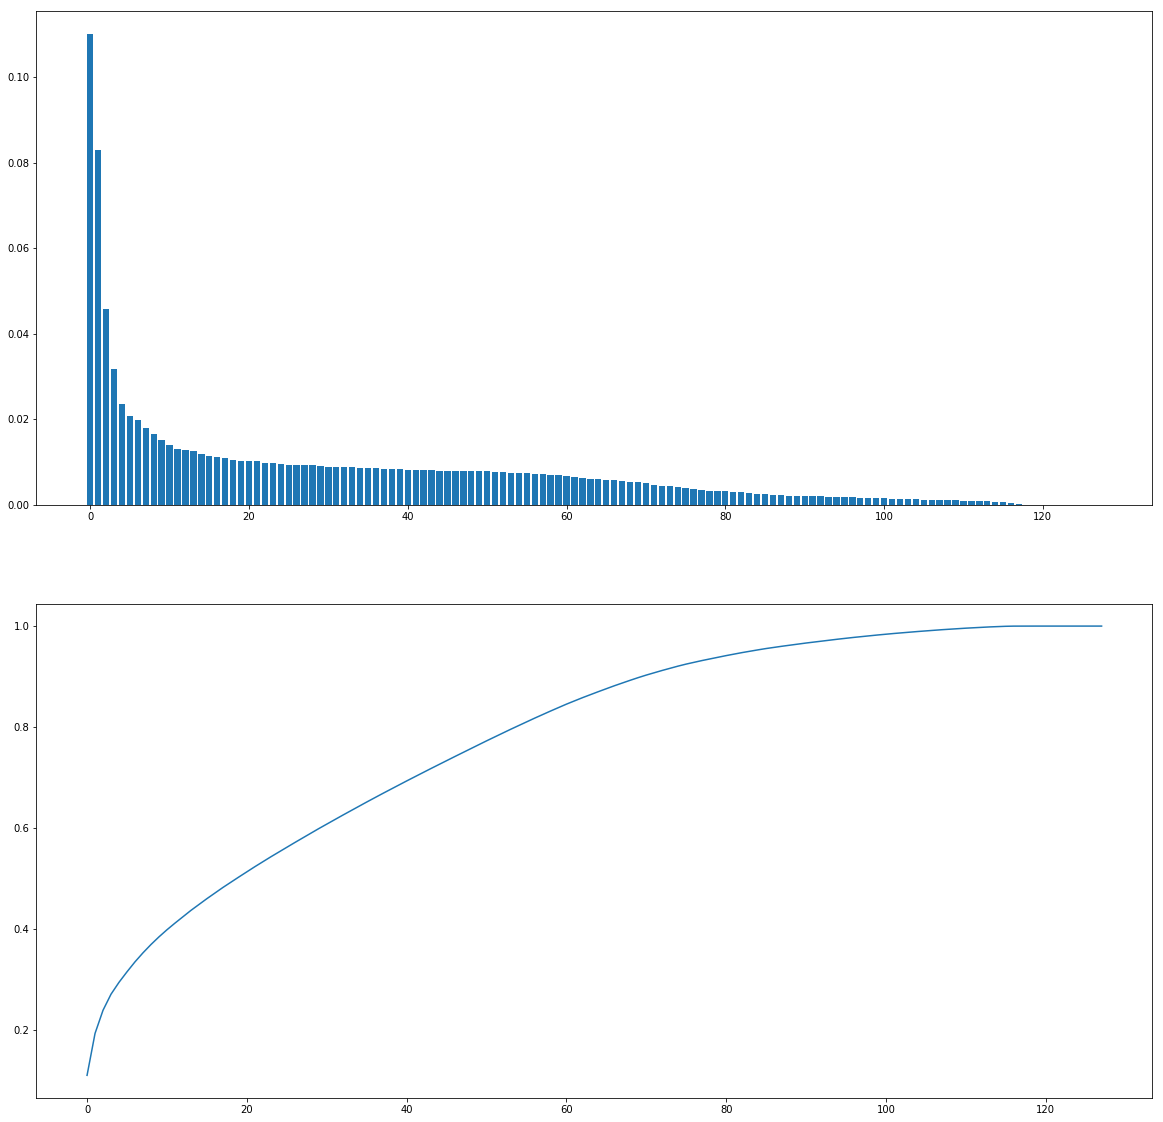

In [199]:
# Investigate the variance accounted for by each principal component.
plt.figure(figsize=(20, 20))
plt.subplot(2,1,1)
plt.bar(list(range(len(pca.explained_variance_ratio_))), pca.explained_variance_ratio_)
plt.subplot(2,1,2)
plt.plot(pca.explained_variance_ratio_.cumsum())

In [200]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_decided = PCA(n_components=6)
pca_decided.fit(X=azdias_informative_dummy_nonan_scaled)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### Discussion 2.2: Perform Dimensionality Reduction

`(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)`

Answer: By using PCA, I just found the variance had a rapid change within the first two componets and became gradual around 5 ~ 6 components. So I decide to have 6 main componets here.
 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.


- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [201]:
# create well-prepared dataframe in order to sort value
main6comps = pd.DataFrame({'features': azdias_informative_dummy_nonan_scaled.columns,
              'comp1': pca_decided.components_.transpose()[:,0],
              'comp2': pca_decided.components_.transpose()[:,1],
              'comp3': pca_decided.components_.transpose()[:,2],
              'comp4': pca_decided.components_.transpose()[:,3],
              'comp5': pca_decided.components_.transpose()[:,4],
              'comp6': pca_decided.components_.transpose()[:,5]})

main6comps.sort_values(by='comp1', ascending=False)

# define a function to print easily
def get_feature_orders_by_componet(componet_number):
    component = eval("'comp' + cp", {'cp': str(componet_number)})
    sorted_result = main6comps.sort_values(by=component, ascending=False)
    return sorted_result[[component, 'features']]



In [202]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

get_feature_orders_by_componet(1)

comp1                        features
87   0.196869              LP_STATUS_GROB_1.0
49   0.194010                      PLZ8_ANTG3
50   0.188893                      PLZ8_ANTG4
51   0.184447                     PLZ8_BAUMAX
126  0.184333          CAMEO_INTL_2015_WEALTH
25   0.181756              HH_EINKOMMEN_SCORE
55   0.169512                     ORTSGR_KLS9
39   0.167847                        EWDICHTE
6    0.145391                FINANZ_HAUSBAUER
48   0.133018                      PLZ8_ANTG2
2    0.132440                   FINANZ_SPARER
36   0.132004                     KBA05_ANTG4
63   0.123673                     FINANZTYP_1
54   0.119244                          ARBEIT
28   0.118410             ANZ_HAUSHALTE_AKTIV
35   0.116369                     KBA05_ANTG3
122  0.115306               CAMEO_DEUG_2015_9
56   0.114557                        RELAT_AB
21   0.100360                   SEMIO_PFLICHT
11   0.097319                       SEMIO_REL
121  0.091841               CAMEO_DEUG_2015_8
124  0.091096    PRAEGENDE_JUGENDJAHRE_DECADE
17   0.082880                       SEMIO_RAT
105  0.082590                      ZABEOTYP_5
81   0.077475             LP_FAMILIE_GROB_1.0
22   0.074928                     SEMIO_TRADV
109  0.071795                 GEBAEUDETYP_3.0
5    0.069637           FINANZ_UNAUFFAELLIGER
12   0.067186                       SEMIO_MAT
10   0.064900                       SEMIO_FAM
..        ...                             ...
27  -0.056694                  WOHNDAUER_2008
85  -0.058975             LP_FAMILIE_GROB_5.0
14  -0.061728                      SEMIO_LUST
15  -0.062658                       SEMIO_ERL
46  -0.065113                KBA13_ANZAHL_PKW
116 -0.066832               CAMEO_DEUG_2015_3
32  -0.072245                        WOHNLAGE
117 -0.073733               CAMEO_DEUG_2015_4
23  -0.075099                    ANZ_PERSONEN
92  -0.076025            NATIONALITAET_KZ_1.0
115 -0.087485               CAMEO_DEUG_2015_2
64  -0.088410                     FINANZTYP_2
125 -0.091121  PRAEGENDE_JUGENDJAHRE_MOVEMENT
101 -0.092498                      ZABEOTYP_1
107 -0.093850                 GEBAEUDETYP_1.0
3   -0.100632                FINANZ_VORSORGER
0   -0.102306            ALTERSKATEGORIE_GROB
41  -0.104595              GEBAEUDETYP_RASTER
38  -0.107425                        BALLRAUM
91  -0.108385              LP_STATUS_GROB_5.0
127 -0.113521       CAMEO_INTL_2015_LIFESTAGE
90  -0.119093              LP_STATUS_GROB_4.0
40  -0.139614                      INNENSTADT
53  -0.142024                        PLZ8_GBZ
30  -0.146185                     KONSUMNAEHE
37  -0.187163                       KBA05_GBZ
47  -0.193494                      PLZ8_ANTG1
33  -0.195423                     KBA05_ANTG1
1   -0.199513               FINANZ_MINIMALIST
43  -0.210243                      MOBI_REGIO

[128 rows x 2 columns]

In [203]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

get_feature_orders_by_componet(2)

comp2                      features
0    0.233159          ALTERSKATEGORIE_GROB
3    0.218167              FINANZ_VORSORGER
103  0.203072                    ZABEOTYP_3
15   0.182945                     SEMIO_ERL
14   0.163844                    SEMIO_LUST
8    0.157897                RETOURTYP_BK_S
26   0.125343                W_KEIT_KIND_HH
58   0.106915             CJT_GESAMTTYP_2.0
6    0.101109              FINANZ_HAUSBAUER
67   0.101064                   FINANZTYP_5
49   0.086576                    PLZ8_ANTG3
64   0.086264                   FINANZTYP_2
50   0.082870                    PLZ8_ANTG4
39   0.082843                      EWDICHTE
55   0.082180                   ORTSGR_KLS9
51   0.078661                   PLZ8_BAUMAX
99   0.077385               SHOPPER_TYP_3.0
18   0.076961                    SEMIO_KRIT
1    0.073997             FINANZ_MINIMALIST
126  0.072004        CAMEO_INTL_2015_WEALTH
57   0.070722             CJT_GESAMTTYP_1.0
20   0.064656                    SEMIO_KAEM
68   0.064531                   FINANZTYP_6
92   0.062506          NATIONALITAET_KZ_1.0
36   0.062500                   KBA05_ANTG4
75   0.061581           GFK_URLAUBERTYP_4.0
54   0.061184                        ARBEIT
48   0.060025                    PLZ8_ANTG2
56   0.058492                      RELAT_AB
28   0.057373           ANZ_HAUSHALTE_AKTIV
..        ...                           ...
60  -0.056353             CJT_GESAMTTYP_4.0
9   -0.063704                     SEMIO_SOZ
30  -0.065231                   KONSUMNAEHE
84  -0.065925           LP_FAMILIE_GROB_4.0
23  -0.066192                  ANZ_PERSONEN
40  -0.066248                    INNENSTADT
53  -0.066452                      PLZ8_GBZ
101 -0.066945                    ZABEOTYP_1
33  -0.072341                   KBA05_ANTG1
80  -0.072576           GFK_URLAUBERTYP_9.0
37  -0.079668                     KBA05_GBZ
65  -0.080365                   FINANZTYP_3
43  -0.081566                    MOBI_REGIO
47  -0.084772                    PLZ8_ANTG1
105 -0.089104                    ZABEOTYP_5
66  -0.093097                   FINANZTYP_4
104 -0.104167                    ZABEOTYP_4
63  -0.123803                   FINANZTYP_1
12  -0.130786                     SEMIO_MAT
10  -0.135145                     SEMIO_FAM
44  -0.164377             ONLINE_AFFINITAET
17  -0.166935                     SEMIO_RAT
16  -0.168297                    SEMIO_KULT
4   -0.201705                FINANZ_ANLEGER
21  -0.206384                 SEMIO_PFLICHT
22  -0.209470                   SEMIO_TRADV
5   -0.214348         FINANZ_UNAUFFAELLIGER
11  -0.215663                     SEMIO_REL
2   -0.221299                 FINANZ_SPARER
124 -0.236711  PRAEGENDE_JUGENDJAHRE_DECADE

[128 rows x 2 columns]

In [204]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

get_feature_orders_by_componet(3)

comp3                        features
13   0.347096                      SEMIO_VERT
9    0.279816                       SEMIO_SOZ
10   0.277849                       SEMIO_FAM
16   0.266190                      SEMIO_KULT
67   0.147152                     FINANZTYP_5
1    0.145845               FINANZ_MINIMALIST
96   0.144269                 SHOPPER_TYP_0.0
101  0.131547                      ZABEOTYP_1
11   0.116939                       SEMIO_REL
12   0.093811                       SEMIO_MAT
8    0.080479                  RETOURTYP_BK_S
26   0.074936                  W_KEIT_KIND_HH
125  0.065697  PRAEGENDE_JUGENDJAHRE_MOVEMENT
3    0.059913                FINANZ_VORSORGER
97   0.058156                 SHOPPER_TYP_1.0
55   0.054138                     ORTSGR_KLS9
39   0.054017                        EWDICHTE
106  0.053210                      ZABEOTYP_6
51   0.050462                     PLZ8_BAUMAX
91   0.048320              LP_STATUS_GROB_5.0
50   0.046532                      PLZ8_ANTG4
49   0.044998                      PLZ8_ANTG3
75   0.032727             GFK_URLAUBERTYP_4.0
48   0.031224                      PLZ8_ANTG2
89   0.030692              LP_STATUS_GROB_3.0
54   0.030532                          ARBEIT
56   0.029977                        RELAT_AB
109  0.029356                 GEBAEUDETYP_3.0
93   0.027984            NATIONALITAET_KZ_2.0
92   0.025919            NATIONALITAET_KZ_1.0
..        ...                             ...
32  -0.031171                        WOHNLAGE
21  -0.032316                   SEMIO_PFLICHT
62  -0.032789               CJT_GESAMTTYP_6.0
94  -0.033017            NATIONALITAET_KZ_3.0
53  -0.035524                        PLZ8_GBZ
103 -0.036475                      ZABEOTYP_3
42  -0.038341                             KKK
41  -0.039057              GEBAEUDETYP_RASTER
25  -0.041326              HH_EINKOMMEN_SCORE
30  -0.043881                     KONSUMNAEHE
38  -0.044069                        BALLRAUM
47  -0.044707                      PLZ8_ANTG1
99  -0.050534                 SHOPPER_TYP_3.0
40  -0.050573                      INNENSTADT
83  -0.052568             LP_FAMILIE_GROB_3.0
100 -0.054621                 SHOPPER_TYP_nan
95  -0.054760            NATIONALITAET_KZ_nan
5   -0.059473           FINANZ_UNAUFFAELLIGER
6   -0.063218                FINANZ_HAUSBAUER
124 -0.063307    PRAEGENDE_JUGENDJAHRE_DECADE
2   -0.070199                   FINANZ_SPARER
104 -0.072544                      ZABEOTYP_4
98  -0.109207                 SHOPPER_TYP_2.0
63  -0.115879                     FINANZTYP_1
4   -0.165966                  FINANZ_ANLEGER
17  -0.169158                       SEMIO_RAT
15  -0.222842                       SEMIO_ERL
18  -0.291988                      SEMIO_KRIT
19  -0.312271                       SEMIO_DOM
20  -0.343237                      SEMIO_KAEM

[128 rows x 2 columns]

**↓↓↓↓↓This three parts are just for back up (the previous version...)↓↓↓↓↓**

In [98]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

#####get_feature_orders_by_componet(1) # for backup

comp1                        features
118  0.185542              LP_STATUS_GROB_1.0
53   0.177094                      PLZ8_ANTG3
210  0.175509          CAMEO_INTL_2015_WEALTH
28   0.174079              HH_EINKOMMEN_SCORE
54   0.172210                      PLZ8_ANTG4
55   0.168688                     PLZ8_BAUMAX
59   0.152008                     ORTSGR_KLS9
43   0.149919                        EWDICHTE
6    0.137724                FINANZ_HAUSBAUER
107  0.126354              LP_STATUS_FEIN_1.0
39   0.125511                     KBA05_ANTG4
52   0.119903                      PLZ8_ANTG2
31   0.113092             ANZ_HAUSHALTE_AKTIV
38   0.112737                     KBA05_ANTG3
40   0.112567                    KBA05_BAUMAX
58   0.109245                          ARBEIT
161  0.107283               CAMEO_DEUG_2015_9
2    0.106539                   FINANZ_SPARER
109  0.103371              LP_STATUS_FEIN_2.0
60   0.102380                        RELAT_AB
68   0.102150                     FINANZTYP_1
101  0.099864             LP_FAMILIE_GROB_1.0
88   0.099864             LP_FAMILIE_FEIN_1.0
160  0.088830               CAMEO_DEUG_2015_8
23   0.074937                   SEMIO_PFLICHT
143  0.074597                      ZABEOTYP_5
13   0.070816                       SEMIO_REL
208  0.070048    PRAEGENDE_JUGENDJAHRE_DECADE
49   0.066806                        REGIOTYP
19   0.065079                       SEMIO_RAT
..        ...                             ...
16  -0.061037                      SEMIO_LUST
155 -0.061119               CAMEO_DEUG_2015_3
35  -0.062762                        WOHNLAGE
156 -0.070231               CAMEO_DEUG_2015_4
69  -0.074292                     FINANZTYP_2
105 -0.079715             LP_FAMILIE_GROB_5.0
3   -0.079821                FINANZ_VORSORGER
0   -0.083498            ALTERSKATEGORIE_GROB
154 -0.084547               CAMEO_DEUG_2015_2
145 -0.086205                 GEBAEUDETYP_1.0
139 -0.093153                      ZABEOTYP_1
42  -0.094229                        BALLRAUM
45  -0.094336              GEBAEUDETYP_RASTER
209 -0.095333  PRAEGENDE_JUGENDJAHRE_MOVEMENT
26  -0.096785                    ANZ_PERSONEN
211 -0.106083       CAMEO_INTL_2015_LIFESTAGE
116 -0.106430              LP_STATUS_FEIN_9.0
121 -0.107249              LP_STATUS_GROB_4.0
108 -0.108394             LP_STATUS_FEIN_10.0
122 -0.108394              LP_STATUS_GROB_5.0
44  -0.124443                      INNENSTADT
9   -0.128836             LP_LEBENSPHASE_GROB
57  -0.130211                        PLZ8_GBZ
33  -0.132176                     KONSUMNAEHE
8   -0.142355             LP_LEBENSPHASE_FEIN
41  -0.177777                       KBA05_GBZ
51  -0.177791                      PLZ8_ANTG1
1   -0.179020               FINANZ_MINIMALIST
36  -0.185751                     KBA05_ANTG1
47  -0.199611                      MOBI_REGIO

[212 rows x 2 columns]

In [99]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

#####get_feature_orders_by_componet(2) # for backup

comp2                      features
0    0.236014          ALTERSKATEGORIE_GROB
3    0.216147              FINANZ_VORSORGER
141  0.198139                    ZABEOTYP_3
17   0.180342                     SEMIO_ERL
16   0.164328                    SEMIO_LUST
10   0.159065                RETOURTYP_BK_S
29   0.128964                W_KEIT_KIND_HH
62   0.105265             CJT_GESAMTTYP_2.0
72   0.095775                   FINANZTYP_5
1    0.095142             FINANZ_MINIMALIST
107  0.089674            LP_STATUS_FEIN_1.0
69   0.088034                   FINANZTYP_2
6    0.075304              FINANZ_HAUSBAUER
131  0.074636               SHOPPER_TYP_3.0
20   0.074120                    SEMIO_KRIT
61   0.068282             CJT_GESAMTTYP_1.0
124  0.068189          NATIONALITAET_KZ_1.0
88   0.066123           LP_FAMILIE_FEIN_1.0
101  0.066123           LP_FAMILIE_GROB_1.0
73   0.064700                   FINANZTYP_6
53   0.060403                    PLZ8_ANTG3
43   0.059941                      EWDICHTE
59   0.059102                   ORTSGR_KLS9
80   0.057028           GFK_URLAUBERTYP_4.0
54   0.056762                    PLZ8_ANTG4
30   0.054311                WOHNDAUER_2008
55   0.053477                   PLZ8_BAUMAX
110  0.050350            LP_STATUS_FEIN_3.0
22   0.049592                    SEMIO_KAEM
210  0.048183        CAMEO_INTL_2015_WEALTH
..        ...                           ...
9   -0.052229           LP_LEBENSPHASE_GROB
64  -0.054285             CJT_GESAMTTYP_4.0
139 -0.054538                    ZABEOTYP_1
41  -0.056006                     KBA05_GBZ
47  -0.056137                    MOBI_REGIO
51  -0.058961                    PLZ8_ANTG1
11  -0.059994                     SEMIO_SOZ
104 -0.067130           LP_FAMILIE_GROB_4.0
70  -0.068319                   FINANZTYP_3
26  -0.069485                  ANZ_PERSONEN
85  -0.074104           GFK_URLAUBERTYP_9.0
112 -0.079739            LP_STATUS_FEIN_5.0
71  -0.088627                   FINANZTYP_4
25  -0.093190                      ALTER_HH
143 -0.093232                    ZABEOTYP_5
109 -0.101660            LP_STATUS_FEIN_2.0
142 -0.107614                    ZABEOTYP_4
14  -0.125809                     SEMIO_MAT
12  -0.127066                     SEMIO_FAM
68  -0.135503                   FINANZTYP_1
48  -0.159761             ONLINE_AFFINITAET
18  -0.161735                    SEMIO_KULT
19  -0.171861                     SEMIO_RAT
4   -0.204995                FINANZ_ANLEGER
24  -0.210634                   SEMIO_TRADV
5   -0.211172         FINANZ_UNAUFFAELLIGER
23  -0.211815                 SEMIO_PFLICHT
13  -0.218584                     SEMIO_REL
2   -0.227337                 FINANZ_SPARER
208 -0.239321  PRAEGENDE_JUGENDJAHRE_DECADE

[212 rows x 2 columns]

In [100]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

#####get_feature_orders_by_componet(3)  # for backup

comp3                        features
15   0.291554                      SEMIO_VERT
11   0.239107                       SEMIO_SOZ
12   0.228745                       SEMIO_FAM
18   0.219233                      SEMIO_KULT
72   0.147723                     FINANZTYP_5
139  0.136361                      ZABEOTYP_1
209  0.134249  PRAEGENDE_JUGENDJAHRE_MOVEMENT
1    0.130832               FINANZ_MINIMALIST
9    0.125625             LP_LEBENSPHASE_GROB
8    0.124379             LP_LEBENSPHASE_FEIN
59   0.123286                     ORTSGR_KLS9
43   0.122331                        EWDICHTE
26   0.116656                    ANZ_PERSONEN
128  0.113656                 SHOPPER_TYP_0.0
105  0.111387             LP_FAMILIE_GROB_5.0
13   0.109024                       SEMIO_REL
108  0.106445             LP_STATUS_FEIN_10.0
122  0.106445              LP_STATUS_GROB_5.0
54   0.085771                      PLZ8_ANTG4
55   0.084971                     PLZ8_BAUMAX
89   0.083745            LP_FAMILIE_FEIN_10.0
53   0.082666                      PLZ8_ANTG3
10   0.077297                  RETOURTYP_BK_S
14   0.073827                       SEMIO_MAT
120  0.064993              LP_STATUS_GROB_3.0
60   0.060916                        RELAT_AB
90   0.058456            LP_FAMILIE_FEIN_11.0
52   0.055781                      PLZ8_ANTG2
58   0.055268                          ARBEIT
40   0.050562                    KBA05_BAUMAX
..        ...                             ...
62  -0.045357               CJT_GESAMTTYP_2.0
103 -0.045682             LP_FAMILIE_GROB_3.0
46  -0.046295                             KKK
121 -0.048757              LP_STATUS_GROB_4.0
77  -0.049400            GFK_URLAUBERTYP_12.0
141 -0.051997                      ZABEOTYP_3
2   -0.052735                   FINANZ_SPARER
142 -0.056402                      ZABEOTYP_4
57  -0.057027                        PLZ8_GBZ
45  -0.060778              GEBAEUDETYP_RASTER
119 -0.064107              LP_STATUS_GROB_2.0
6   -0.072319                FINANZ_HAUSBAUER
51  -0.072450                      PLZ8_ANTG1
109 -0.074864              LP_STATUS_FEIN_2.0
33  -0.077838                     KONSUMNAEHE
28  -0.086314              HH_EINKOMMEN_SCORE
35  -0.093214                        WOHNLAGE
68  -0.095159                     FINANZTYP_1
130 -0.097345                 SHOPPER_TYP_2.0
42  -0.097369                        BALLRAUM
44  -0.105034                      INNENSTADT
88  -0.112076             LP_FAMILIE_FEIN_1.0
101 -0.112076             LP_FAMILIE_GROB_1.0
111 -0.125612              LP_STATUS_FEIN_4.0
19  -0.131687                       SEMIO_RAT
4   -0.161217                  FINANZ_ANLEGER
17  -0.183194                       SEMIO_ERL
21  -0.234474                       SEMIO_DOM
20  -0.253011                      SEMIO_KRIT
22  -0.263631                      SEMIO_KAEM

[212 rows x 2 columns]

**↑↑↑↑↑This three parts are just for back up (the previous version...)↑↑↑↑↑**

### Discussion 2.3: Interpret Principal Components

`(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)`

Answer:




##### Component 1: Socio-economic Status
| weight | feature | meaning |
| ---- | ---- | ---- | 
|0.196869	|LP_STATUS_GROB_1.0|        low-income earners    |
|0.194010	|PLZ8_ANTG3|                Number of 6-10 family houses in the PLZ8 region (The larger the number, the more share of 6-10 family homes)    |
|0.188893	|PLZ8_ANTG4|                Number of 10+ family houses in the PLZ8 region. (The larger the number , the more share of 10+  family homes) |  
|0.184447	|PLZ8_BAUMAX|               Most common building type within the PLZ8LP_STATUS_GROB_1 region. (The larger the number , the more share of 10+  family homes) |   
|0.184333	|CAMEO_INTL_2015_WEALTH|    Wealth Typology (The larger the number, the poorer the wealth status)    |
|-----  |----- |----- |
|-0.187163	|KBA05_GBZ|                 Number of buildings in the microcell. (The larger the number, the more buildings)    |
|-0.193494	|PLZ8_ANTG1|                Number of 1-2 family houses in the PLZ8 region. (The larger the number, the more share of 1-2 family homes)   | 
|-0.195423	|KBA05_ANTG1|               Number of 1-2 family houses in the microcell. (The larger the number, the more share of 1-2 family homes)    |
|-0.199513	|FINANZ_MINIMALIST|         Financial typology (low financial interest). (The larger the number, the lower the financial status)    |
|-0.210243	|MOBI_REGIO|                Movement patterns. (The larger the number, the lower the movement)    |


It looks like component 1 is more like a person's socio-economic status.
The positive values show lower socio-economic traits: lower-income, big family composition (6~10+ family houses). 
The negative values show higher socio-economic traits: less buildings in a microcell, smaller family composition (1-2 family houses), 
higher financial status and higher movement patterns. 

I named componet 1 as `Socio-economic Status`.



##### Component 2: Social Stability Characteristic
| weight | feature | meaning |
| ---- | ---- | ---- | 
|0.233159	|ALTERSKATEGORIE_GROB|              Estimated age based on given name analysis. (The larger the number, the older the age)|
|0.218167	|FINANZ_VORSORGER|                  Financial typology (be prepared). (The larger the number, the lower the financial status)|
|0.203072	|ZABEOTYP_3|                        Energy consumption typology: fair supplied|
|0.182945	|SEMIO_ERL|                         Personality typology (event-oriented): (The larger the number, the lower the affinity)|
|0.163844	|SEMIO_LUST|                        Personality typology (sensual-minded): (The larger the number, the lower the affinity)|
|-----  |----- |----- |
|-0.209470	|SEMIO_TRADV|                       Personality typology (tradional-minded): (The larger the number, the lower the affinity)|
|-0.214348	|FINANZ_UNAUFFAELLIGER|             Financial typology (inconspicuous). (The larger the number, the lower the financial status)|
|-0.215663	|SEMIO_REL|                         Personality typology (religious): (The larger the number, the lower the affinity)|
|-0.221299	|FINANZ_SPARER|                     Personality typology (money-saver): (The larger the number, the lower the affinity)|
|-0.236711	|PRAEGENDE_JUGENDJAHRE_DECADE|      PRAEGENDE_JUGENDJAHRE (Dominating movement of person's youth):  (The larger the number, the more closer to 90s)|



Componets 2 is a little ambiguos. However, THere some interesting characteristics here. 
For the positve value, 
it is closed to older, low financial status, not event-oriented and not sensual-minded personality, which is closed to marginalized populations.
For the negative value,
it shows higher financial status, more tradional-minded, more religious, more like a money-saver and has earlier dominating movement, which is more like socially stable people.

I named componet 2 as `Social Stability Characteristic`.



##### Component 3: Socialized Personality (peacefulness)
| weight | feature | meaning |
| ---- | ---- | ---- | 
|0.347096	|SEMIO_VERT|    Personality typology (dreamful): (The larger the number, the lower the affinity)|
|0.279816	|SEMIO_SOZ|     Personality typology (socially-minded): (The larger the number, the lower the affinity)|
|0.277849	|SEMIO_FAM|     Personality typology (family-minded): (The larger the number, the lower the affinity)|
|0.266190	|SEMIO_KULT|    Personality typology (cultural-minded): (The larger the number, the lower the affinity)|
|0.147152	|FINANZTYP_5|   Most descriptive financial type for individual: investor|
|-----  |----- |----- |
|-0.169158	|SEMIO_RAT|     Personality typology (rational): (The larger the number, the lower the affinity)|
|-0.222842	|SEMIO_ERL|     Personality typology (event-oriented): (The larger the number, the lower the affinity)|
|-0.291988	|SEMIO_KRIT|    Personality typology (critical-minded): (The larger the number, the lower the affinity)|
|-0.312271	|SEMIO_DOM|     Personality typology (dominant-minded): (The larger the number, the lower the affinity)|
|-0.343237	|SEMIO_KAEM|    Personality typology (combative attitude): (The larger the number, the lower the affinity)|


Component 3 is composed of personality features mostly. 
Positive values appear to be more socialized (dreamful, socially-minded, family-minded and cultural-minded).
Negative values are seemed to be more aggressive (rational, event-oriented, dominant-minded, critical-minded and ombative attitude) characteristics.

I named componet 3 as `Socialized Personality (peacefulness)`.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [205]:
pca_transformed = pca_decided.transform(azdias_informative_dummy_nonan_scaled)

In [206]:
start = time.time()

# Over a number of different cluster counts...
k_list = []
score_list = []

for k in range(1,31):
    # run k-means clustering on the data and...
    kmeans = KMeans(k)
    model = kmeans.fit(pca_transformed)

    # compute the average within-cluster distances.
    score = model.score(pca_transformed)
    k_list.append(k)
    score_list.append(abs(score))     
    
elapsed_time = time.time() - start
print ("elapsed_time: {0}".format(elapsed_time/60) + " minutes.")    

elapsed_time: 133.72589801549913 minutes.


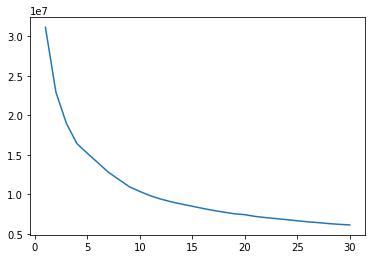

In [207]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(k_list, score_list)

In [208]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

start = time.time()
# k = 30
kmeans = KMeans(30)
kmeans_model = kmeans.fit(pca_transformed)  

In [209]:
general_population_clusters = kmeans_model.predict(pca_transformed)

elapsed_time = time.time() - start
print ("elapsed_time: {0}".format(elapsed_time/60) + " minutes.")  

elapsed_time: 13.096280650297802 minutes.


In [210]:
general_population_clusters

array([ 5, 23, 21, ...,  0, 10,  4], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

`(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)`


Answer:
With the plot of `number of clusters` and `average distance to centroids (score)`, it is showed that as number of clusters increases, the net benefits become tiny. The change of score becomes stable around 30 clusters, in which I decided to use `30` as the number of clusters in the following steps.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [211]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [228]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
start = time.time()

customers_clean = clean_data(customers)

print('** imputation  **')
# From udacity:  Instead of just using dropna, you should do imputation here. 
my_imputer = Imputer()
data_with_imputed_values = my_imputer.fit_transform(customers_clean)
customers_clean_nonan = pd.DataFrame(data=data_with_imputed_values, columns=customers_clean.columns)

print('** Additional Processing  **')
# Additional Processing
# Since the customer data does not inlclude some specific values, 
# the folloing column was not made in the dummy variable process .
# Create the column here.
customers_clean_nonan['GEBAEUDETYP_5.0'] = 0

print('** feature scaling  **')
# Apply feature scaling to the customer demographics data.
customers_clean_nonan_scaled = scale.transform(customers_clean_nonan) # don't want to bias your model with information from the test data.
customers_clean_nonan_scaled = pd.DataFrame(data=customers_clean_nonan_scaled, columns=customers_clean_nonan.columns)

# PCA
print('** PCA  **')
customers_pca_transformed = pca_decided.transform(customers_clean_nonan_scaled)
customers_clusters = kmeans_model.predict(customers_pca_transformed)

elapsed_time = time.time() - start
print ("elapsed_time: {0}".format(elapsed_time/60) + " minutes.")  

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


** imputation  **
** Additional Processing  **
** feature scaling  **
** PCA  **
elapsed_time: 0.5670146663983663 minutes.


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'customer_population_clusters')

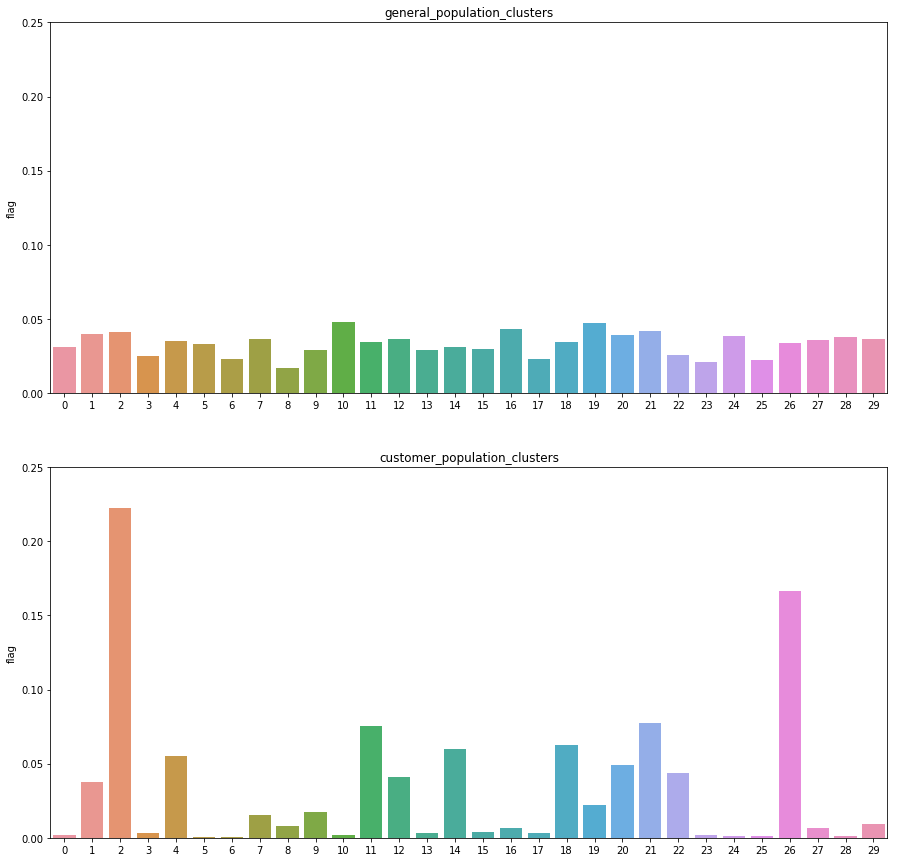

In [231]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

gp_clusters_df = pd.DataFrame(data=general_population_clusters, columns=['flag'])['flag'].value_counts()/len(general_population_clusters)
ct_clusters_df = pd.DataFrame(data=customers_clusters, columns=['flag'])['flag'].value_counts()/len(customers_clusters)

plt.figure(figsize=(15,15))

plt.subplot(2,1,1)
sns.barplot(x=gp_clusters_df.index, y=gp_clusters_df)
plt.ylim(0, 0.25)
plt.title('general_population_clusters')

plt.subplot(2,1,2)
sns.barplot(x=ct_clusters_df.index, y=ct_clusters_df)
plt.ylim(0, 0.25)
plt.title('customer_population_clusters')

In [232]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# cluster 2, 26
print(kmeans_model.cluster_centers_[2,:])
print(kmeans_model.cluster_centers_[26,:])
# >> Social Stability Characteristic is strong

[-4.81215284  1.24081747  1.76911381 -2.20155993  0.26916337  0.40209371]
[-4.13977337  1.53851567  3.2556902   1.87276342 -1.49343486  0.06922553]


In [234]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# cluster 10
print(kmeans_model.cluster_centers_[10,:])

# >> Social Stability Characteristic is weak, while Socialized Personality (peacefulness) is strong

[ 5.81143662 -2.16620011  3.04267538 -0.14345913  0.52544533 -0.32223842]


### Discussion 3.3: Compare Customer Data to Demographics Data

`(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)`


Answer:
##### population that are relatively popular with the mail-order company
From the above analysis and comparison, cluster 2 and 26 are popular with the company compared to the general population. In cluster 2 and 26, PCA components 1 `Socio-economic Status`  has the maximum negative weight and PCA components 3 `Socialized Personality (peacefulness)` has highly positive weight. That is, it can be inferred that higher socio-economic people who lives in less buildings in a microcell, has smaller family composition (1-2 family houses) and higher movement patterns are more likely to be the users of the mail-order company. The personality of that kind of people are more socialized (dreamful, socially-minded, family-minded and cultural-minded), who might be a entrepreneur or a manager.

##### population that are relatively unpopular with the company
In contrast, cluster 10 is unpopular with the company, where the PCA componets 2 `Social Stability Characteristic` is with highly negative weight and PCA componet 1 `Socio-economic Status` has highly positive weight. In the other words, for the people 
with higher financial status, more tradional-minded, more religious, more like a money-saver and big family composition, they tend to be indifferent with the company. They might be relatively conservatve people. The company does not need to pay much attention to this kind of population. However, it might be a bottleneck if the company wants to penetrate into this group.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.